<a href="https://colab.research.google.com/github/BunnyNoBugs/minor2021-iad3-spring/blob/main/hw4/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 4: Прогнозирование временных рядов</center></h2>

# Введение

В этом задании Вам предстоит разобраться с основами анализа и прогнозирования временных рядов. 


![image](https://imgs.xkcd.com/comics/extrapolating.png)

In [ ]:
!pip install orbit-ml
!pip install prophet
!pip install sktime[all_extras]

     |████████████████████████████████| 112kB 7.4MB/s 
     |████████████████████████████████| 634kB 12.1MB/s 
     |████████████████████████████████| 9.5MB 15.4MB/s 
     |████████████████████████████████| 11.6MB 26.7MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


     |████████████████████████████████| 71kB 4.6MB/s 
     |████████████████████████████████| 51kB 1.1MB/s 
     |████████████████████████████████| 184kB 13.1MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-cp37-none-any.whl size=6639061 sha256=62602d78fef1269a1e5a3244addd086fc7aa052d535230a5a8fffd5f9945e4db
  Stored in directory: /root/.cache/pip/wheels/92/1d/02/bc0a91bd3a84e060722075d2b0b68e875e37ec7dc49451d513
Successfully built prophet
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.68 which is incompatible.
  Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
     |████████████████████████████████| 5.7MB 6.9MB/s 
     |████████████████████████████████| 22.3MB 1.6MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done

In [ ]:
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from itertools import combinations

## Задание 1 (2 балла). Поиск и предобработка данных.

В этом задании Вам необходимо _самостоятельно_ найти два временных ряда: один должен обладать месячной частотой, а второй — дневной.

Мы советуем поискать соответствующие временные ряды на платформе [kaggle](https://www.kaggle.com/datasets) или же взять один из [популярных](https://medium.com/analytics-vidhya/10-time-series-datasets-for-practice-d14fec9f21bc) временных рядов для анализа. 

**Не рекоммендуется** использовать в качестве временных рядов цены финансовых инструментов в силу плохой предсказуемости изменения цен. **Запрещается** использовать готовые наборы данных из библиотек для анализа временных рядов, например, `from orbit.utils.dataset import load_iclaims`.

![bitcoin](https://avatars.mds.yandex.net/get-zen_doc/3417386/pub_6017dd4b8d30cb1780864ae0_6017f4aa8d30cb1780bf66ce/scale_1200)




В качестве отчета по заданию:

* Опишите источники временных рядов (ссылки на страницы скачивания). В случае, если данные требовали дополнительной обработки, приведите код этой обработки, загрузите данные в личное облачное хранилище и приведите ссылку на скачивание. Процесс получения временных рядов должен быть **четко** расписан и полностью **воспроизводиться**. 

* Приведите код считывания временных рядов из файлов и разделения на train/test. Соотношение размеров train/test на Ваше усмотрение, но мы советуем Вам выбрать 80% на 20%, если в test остаётся хотя бы пара лет наблюдений.



Оба датасета я взял из предложенного [источника](https://medium.com/analytics-vidhya/10-time-series-datasets-for-practice-d14fec9f21bc). Автор статьи выложил датасеты на свой гитхаб. Из них остается удалить прогнозы и оставить только реальные наблюдения, а также перевести время наблюдений в формат `datetime`. Кроме того, дневной временной ряд я обрезаю до того места, в котором появляется сложнообъяснимый выброс, который сильно увеличивает значение ошибки и не позволяет корректно оценить осмысленные предсказания.

In [ ]:
# # скачаем данные
# !wget timeseries1_link
# !wget timeseries2_link

In [ ]:
# считаем файлы
ts1 = pd.read_csv('https://raw.githubusercontent.com/rishabh89007/Time_Series_Datasets/main/Brent%20Spot%20Price.csv', index_col=0)
ts1 = ts1[ts1.index.map(lambda x: x <= '2021 03 ')]
ts1.index = pd.PeriodIndex(ts1.index, freq='M')
ts2 = pd.read_csv('https://raw.githubusercontent.com/rishabh89007/Time_Series_Datasets/main/Nuclear%20Capacity.csv', index_col=0)
ts2 = ts2[ts2.index.map(lambda x: x < '2020 1107 07')]
ts2.index = ts2.index.map(lambda x: pd.to_datetime(x[:-3], format='%Y %m%d'))
ts2.index = pd.PeriodIndex(ts2.index, freq='D')

In [ ]:
# сделаем разбиение на train/test

ts1_test_size = int(len(ts1) * 0.2)
ts1_train = ts1['Brent crude oil spot price, Monthly (dollars per barrel)'][:-ts1_test_size]
ts1_test = ts1['Brent crude oil spot price, Monthly (dollars per barrel)'][-ts1_test_size:]

ts2_test_size = int(len(ts2) * 0.2)
ts2_train = ts2['U.S. nuclear capacity, daily (Megawatts)'][:-ts2_test_size]
ts2_test = ts2['U.S. nuclear capacity, daily (Megawatts)'][-ts2_test_size:]

## Задание 2. Анализ временных рядов (1 балла).

* Отрисуйте временные ряды и визуально сделайте различимым разбиение на выборки — либо вертикальной чертой, либо разными цветами.

* Постройте графики автокорреляционных функций для выбранных временных рядов. Прокомментируйте их: являются ли временные ряды сезонными? Видна ли на графиках длина сезонной составляющей ряда?

* В случае присутствия сезонности, разбейте временной ряд на повторяющиеся фрагменты и нарисуйте их наложенными для иллюстрации этой сезонности.

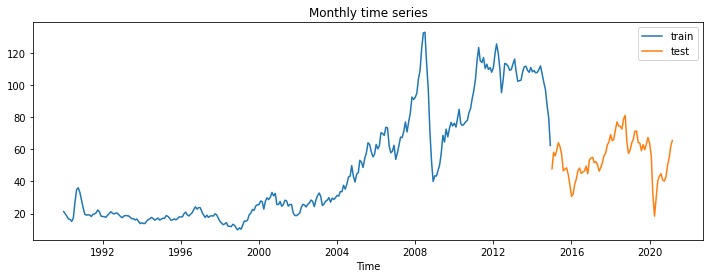

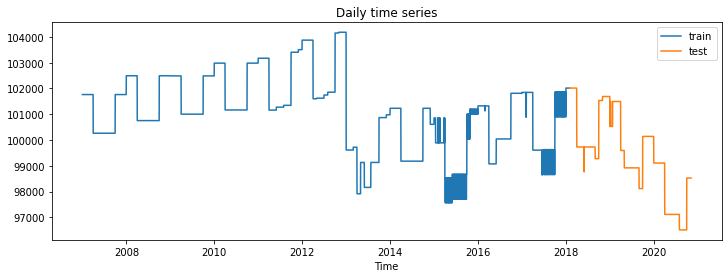

In [ ]:
# отрисуем временные ряды
plt.figure(figsize=(12, 4))
plt.plot(ts1_train.index.to_timestamp(), ts1_train, label='train')
plt.plot(ts1_test.index.to_timestamp(), ts1_test, label='test')
plt.legend()
plt.title('Monthly time series')
plt.xlabel('Time')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(ts2_train.index.to_timestamp(), ts2_train, label='train')
plt.plot(ts2_test.index.to_timestamp(), ts2_test, label='test')
plt.legend()
plt.title('Daily time series')
plt.xlabel('Time')
plt.show()

In [ ]:
# посчитайте и нарисуйте график автокорреляционной функции
# hint, используйте для этого np.correlate(..., mode='full')

In [ ]:
def autocorrelation(ts):
    ts_centered = ts - ts.mean()
    autocorr = np.correlate(ts_centered, ts_centered, mode='full')[len(ts_centered) - 1:]
    autocorr /= autocorr.max()

    return autocorr

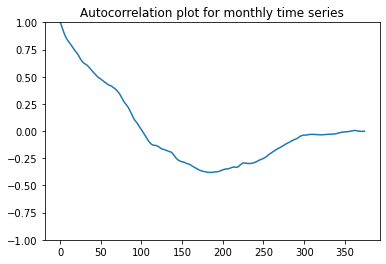

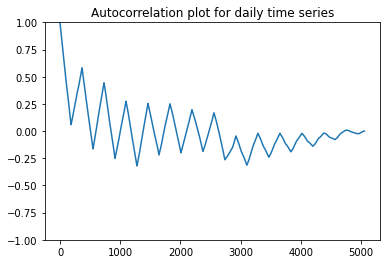

In [ ]:
ts1_array = ts1['Brent crude oil spot price, Monthly (dollars per barrel)'].to_numpy()
ts1_autocorr = autocorrelation(ts1_array)
plt.plot(ts1_autocorr)
plt.ylim(-1, 1)
plt.title('Autocorrelation plot for monthly time series')
plt.show()

ts2_array = ts2['U.S. nuclear capacity, daily (Megawatts)'].to_numpy()
ts2_autocorr = autocorrelation(ts2_array)
plt.plot(ts2_autocorr)
plt.ylim(-1, 1)
plt.title('Autocorrelation plot for daily time series')
plt.show()

Отчетливо видно, что первый временной ряд (с месячной частотой) обладает трендом, но не обладает сезонностью, а второй временной ряд (с дневной частотой) обладает сезонностью, но не обладает трендом.

In [ ]:
# разбейте временной ряд на повторяющиеся участки по длине сезонной составляющей и нарисуйте их наложенными

In [ ]:
def season_plot(ts_array, season):
    curr_idx = 0
    end_idx = 0
    fragments = []
    while end_idx <= len(ts_array):
        curr_idx = end_idx
        end_idx = curr_idx + season
        if end_idx > len(ts_array):
            seasonal_fragment = ts_array[curr_idx:].copy()
        else:
            seasonal_fragment = ts_array[curr_idx:end_idx].copy()
        if seasonal_fragment.size == season:
            fragments.append(seasonal_fragment)
        if seasonal_fragment.size != 0:
            seasonal_fragment -= seasonal_fragment[0]
        plt.plot(seasonal_fragment, color='tab:blue')
    plt.title(f'Season = {season}')
    plt.show()
    distances = []
    for pair in combinations(fragments, 2):
        distances.append(np.linalg.norm(pair[0] - pair[1]))
    distances = np.array(distances)
    print('Mean Euclidean distance between fragments:', distances.mean())

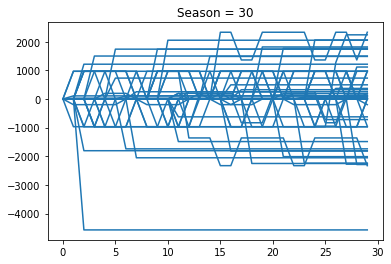

Mean Euclidean distance between fragments: 3328.433947381979


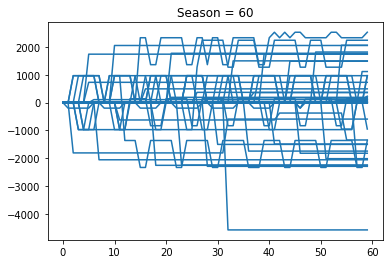

Mean Euclidean distance between fragments: 7530.136066048569


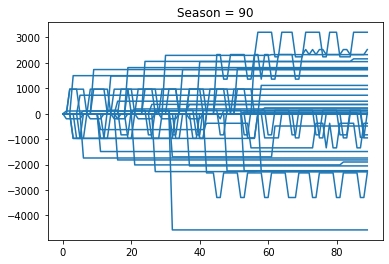

Mean Euclidean distance between fragments: 14390.265720469602


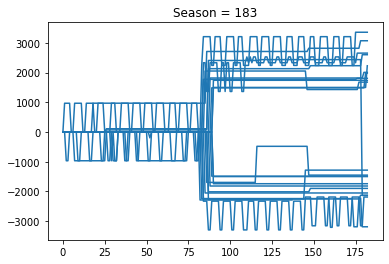

Mean Euclidean distance between fragments: 24451.90243562726


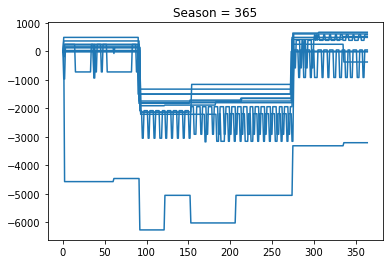

Mean Euclidean distance between fragments: 21836.141739339393


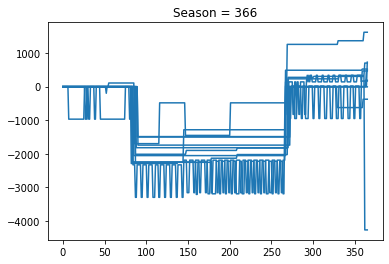

Mean Euclidean distance between fragments: 12824.573669089394


In [ ]:
for season in [30, 60, 90, 183, 365, 366]:
    season_plot(ts2_train.to_numpy(), season)

## Задание 3. Предсказание месячного временного ряда (4.5 балла).

В этом задании Вам предстоит попробовать предсказать месячный временной несколькими готовыми моделями со скользящим или растущим окном и выбрать среди них наилучшую.

В качестве метрики сравнения используйте MAE между истинными и предсказанными значениями ряда на тестовом отрезке.


### NaiveForecaster из sktime (0.5 балл).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [ ]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_absolute_error

In [ ]:
# ваш код обучения моделей здесь

In [ ]:
# посчитайте метрики на test

In [ ]:
fh = ForecastingHorizon(ts1_test.index, is_relative=False)

11.566026666666668


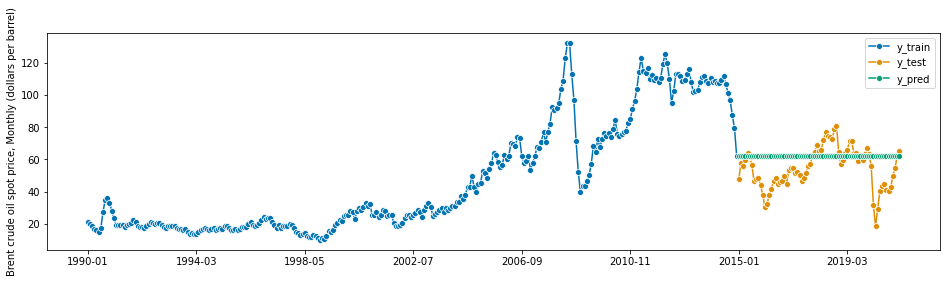

In [ ]:
forecaster = NaiveForecaster(strategy='last')
forecaster.fit(ts1_train)
ts1_pred = forecaster.predict(fh)
plot_series(ts1_train, ts1_test, ts1_pred, labels=["y_train", "y_test", "y_pred"])
print(mean_absolute_error(ts1_pred, ts1_test))

In [ ]:
for sp in range(1, 13):
    forecaster = NaiveForecaster(strategy='last', sp=sp)
    forecaster.fit(ts1_train)
    ts1_pred = forecaster.predict(fh)
    print(f'Seasonality: {sp} MAE: {mean_absolute_error(ts1_pred, ts1_test)}')

Seasonality: 1 MAE: 11.566026666666668
Seasonality: 2 MAE: 18.14618666666667
Seasonality: 3 MAE: 22.890093333333333
Seasonality: 4 MAE: 27.980759999999997
Seasonality: 5 MAE: 31.833546666666663
Seasonality: 6 MAE: 35.37381333333333
Seasonality: 7 MAE: 38.451119999999996
Seasonality: 8 MAE: 40.55045333333333
Seasonality: 9 MAE: 42.26309333333334
Seasonality: 10 MAE: 43.525013333333334
Seasonality: 11 MAE: 44.431760000000004
Seasonality: 12 MAE: 44.769346666666664


Видно, что учет сезонности не дает прироста качества.

### ARIMA/AutoArima (1 балл).

Обучите из библиотеки `sktime` модели:

* SARIMA(1, 1, 1)(1, 0, 0)[12] (`ARIMA` в `sktime`)
* Алгоритм Хиндмана-Хандакара подбора SARIMA (`AutoARIMA` в `sktime`)

In [ ]:
from sktime.forecasting.arima import ARIMA, AutoARIMA

# ваш код обучения моделей здесь

In [ ]:
# посчитайте метрики на test

11.060365604093649


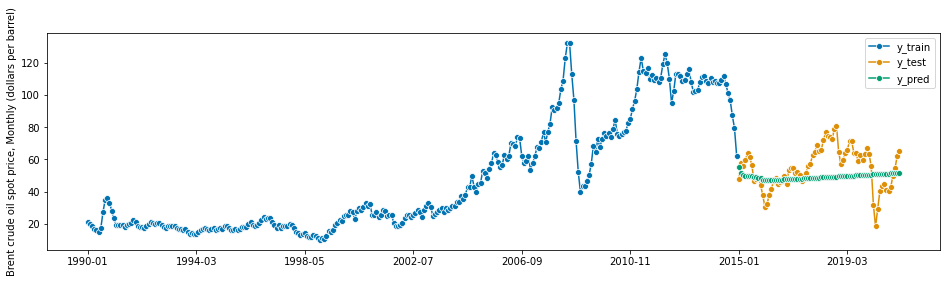

In [ ]:
forecaster = ARIMA(order=(1, 1, 1), seasonal_order=(1, 0, 0, 12))
forecaster.fit(ts1_train)
ts1_pred = forecaster.predict(fh)
plot_series(ts1_train, ts1_test, ts1_pred, labels=["y_train", "y_test", "y_pred"])
print(mean_absolute_error(ts1_pred, ts1_test))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


8.772098427723153
CPU times: user 13 s, sys: 9.28 s, total: 22.3 s
Wall time: 11.5 s


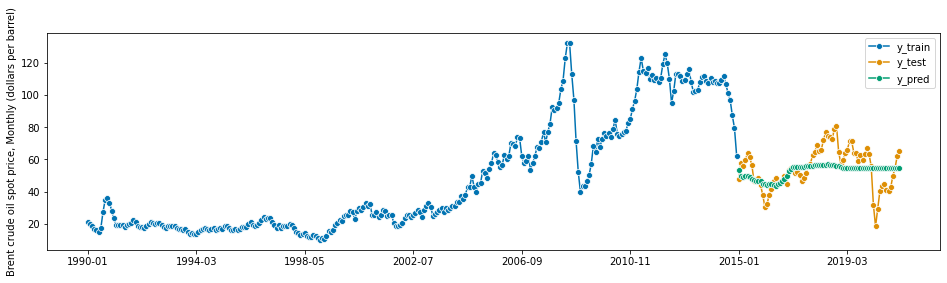

In [ ]:
%%time

forecaster = AutoARIMA(sp=12, start_p=1, d=1, start_q=1, start_P=1, D=0, start_Q=0, maxiter=500)
forecaster.fit(ts1_train)
ts1_pred = forecaster.predict(fh)
plot_series(ts1_train, ts1_test, ts1_pred, labels=["y_train", "y_test", "y_pred"])
print(mean_absolute_error(ts1_pred, ts1_test))

### LGT/DLT (1 балл).

Обучите из библиотеки `orbit` модели LGT и DLT

In [ ]:
from orbit.models.lgt import LGTFull
from orbit.models.dlt import DLTFull

from orbit.diagnostics.plot import plot_predicted_data
# ваш код обучения моделей здесь

In [ ]:
# посчитайте метрики на test

In [ ]:
def ts2df(ts):
    df = pd.DataFrame(ts)
    df.index = pd.DatetimeIndex(df.index.to_timestamp())
    df = df.reset_index()

    return df

In [ ]:
ts1_train_df = ts2df(ts1_train)
ts1_test_df = ts2df(ts1_test)

In [ ]:
%%time

lgt = LGTFull(
    response_col='Brent crude oil spot price, Monthly (dollars per barrel)',
    date_col='index',
    seasonality=12
)
lgt.fit(df=ts1_train_df)
ts1_pred = lgt.predict(df=ts1_test_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 177 ms, sys: 115 ms, total: 292 ms
Wall time: 8.67 s


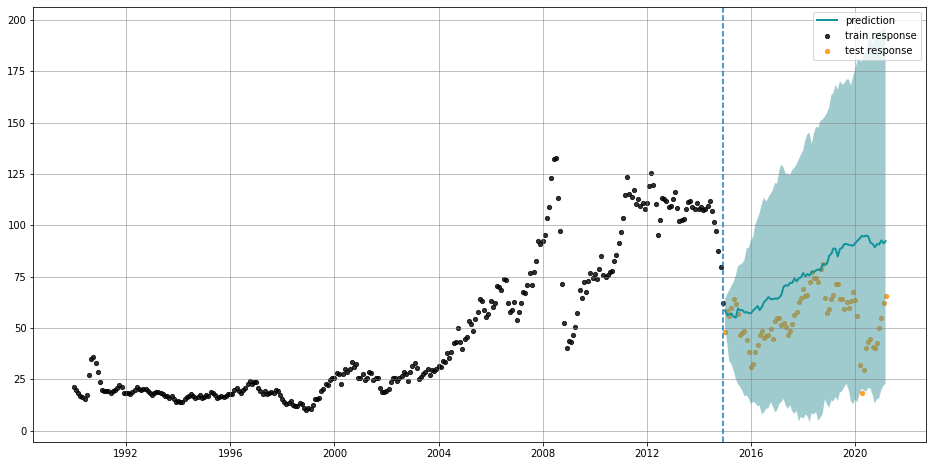

21.136967160743293


In [ ]:
plot_predicted_data(
    training_actual_df=ts1_train_df, predicted_df=ts1_pred,
    date_col=lgt.date_col, actual_col=lgt.response_col,
    test_actual_df=ts1_test_df
)
print(mean_absolute_error(ts1_pred['prediction'], ts1_test))

In [ ]:
%%time

dlt = DLTFull(
    response_col='Brent crude oil spot price, Monthly (dollars per barrel)',
    date_col='index',
    seasonality=12
)
dlt.fit(df=ts1_train_df)
ts1_pred = dlt.predict(df=ts1_test_df)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b0a449c7523386cce384e92a998e71c8 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 1.46 s, sys: 237 ms, total: 1.7 s
Wall time: 1min 21s


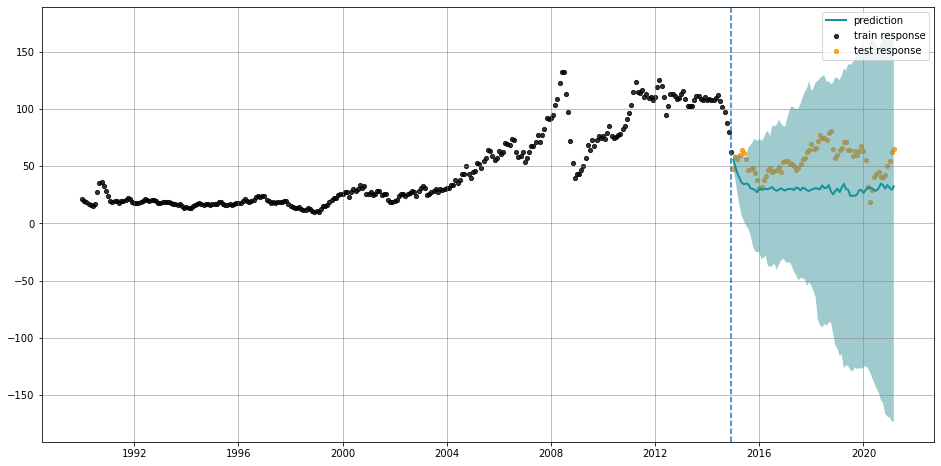

24.44822276468388


In [ ]:
plot_predicted_data(
    training_actual_df=ts1_train_df, predicted_df=ts1_pred,
    date_col=dlt.date_col, actual_col=dlt.response_col,
    test_actual_df=ts1_test_df
)
print(mean_absolute_error(ts1_pred['prediction'], ts1_test))

### ETS (2 балла).

Обучите из библиотеки `sklearn` модели:

* ETS(AAA) (`ExponentialSmoothing` в `sktime`)
* ETS с автоматическим выбором по AIC (`AutoETS` в `sktime`)

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

# ваш код обучения моделей здесь

In [ ]:
# посчитайте метрики на test

16.294817867464303


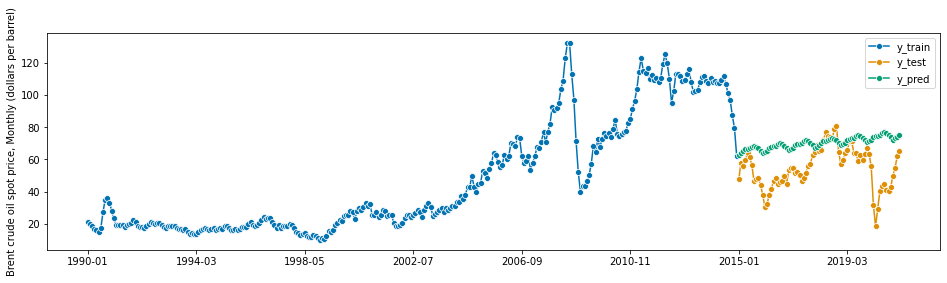

In [ ]:
forecaster = ExponentialSmoothing(trend='add', seasonal='add', sp=12)
forecaster.fit(ts1_train)
ts1_pred = forecaster.predict(fh)
plot_series(ts1_train, ts1_test, ts1_pred, labels=["y_train", "y_test", "y_pred"])
print(mean_absolute_error(ts1_pred, ts1_test))

11.943925462742861


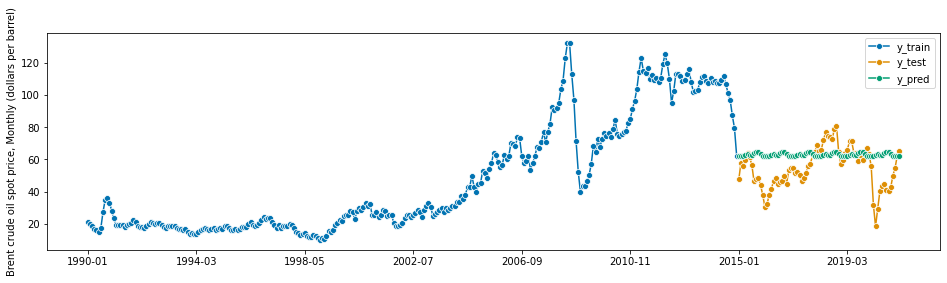

In [ ]:
forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)
forecaster.fit(ts1_train)
ts1_pred = forecaster.predict(fh)
plot_series(ts1_train, ts1_test, ts1_pred, labels=["y_train", "y_test", "y_pred"])
print(mean_absolute_error(ts1_pred, ts1_test))

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения. В `sktime` `ETS` модель пока ещё не выдаёт доверительные интервалы, но при желании до них можно дотянуться :)

In [ ]:
# нарисуйте пресказания

In [ ]:
%%time

forecaster = AutoARIMA(sp=12, start_p=1, d=1, start_q=1, start_P=1, D=0, start_Q=0, maxiter=500)
forecaster.fit(ts1_train)
ts1_pred, ts1_pred_ints = forecaster.predict(fh, return_pred_int=True)
ts1_pred = pd.DataFrame(ts1_pred, columns=['prediction'])
ts1_pred = pd.concat([ts1_pred, ts1_pred_ints], axis=1)
ts1_pred = ts1_pred.rename(columns={'lower': 'prediction_5', 'upper': 'prediction_95'})
ts1_pred.index = ts1_pred.index.to_timestamp()
ts1_pred = ts1_pred.reset_index()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


CPU times: user 12.7 s, sys: 8.96 s, total: 21.6 s
Wall time: 11 s


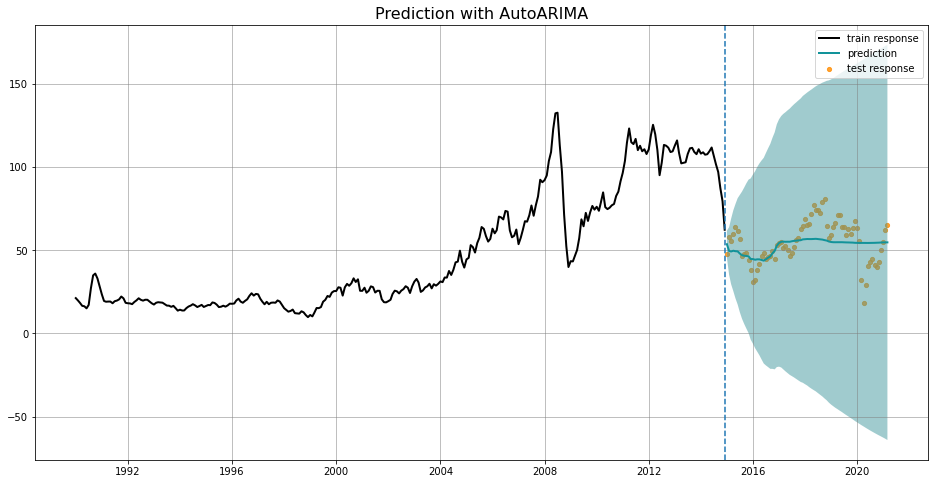

MAE: 8.772098427723153


In [ ]:
plot_predicted_data(
    training_actual_df=ts1_train_df, predicted_df=ts1_pred,
    date_col='index', actual_col='Brent crude oil spot price, Monthly (dollars per barrel)',
    test_actual_df=ts1_test_df,
    insample_line=True,
    title='Prediction with AutoARIMA'
)
print('MAE:', mean_absolute_error(ts1_pred['prediction'], ts1_test))

## Задание 4. Предсказание дневного временного ряда (2.5 балла).

В этом задании Вам предстоит попробовать предсказать выбранный Вами дневной временной ряд.

Аналогично, в качестве метрики используем MAE.



### NaiveForecaster из sktime (0.5 балла).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [ ]:
from sktime.forecasting.naive import NaiveForecaster

# ваш код обучения моделей здесь

In [ ]:
# посчитайте метрики на test

In [ ]:
fh = ForecastingHorizon(ts2_test.index, is_relative=False)

2571.851038575669


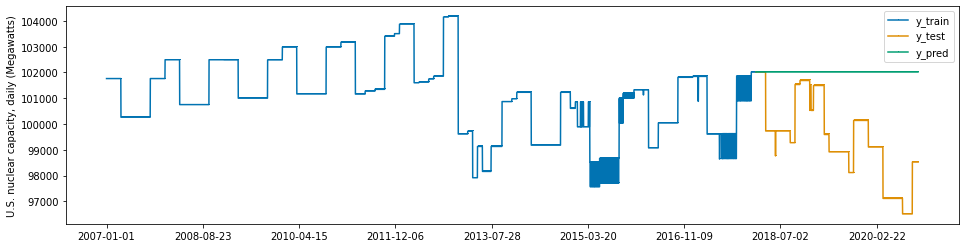

In [ ]:
forecaster = NaiveForecaster(strategy='last')
forecaster.fit(ts2_train)
ts2_pred = forecaster.predict(fh)
plot_series(ts2_train, ts2_test, ts2_pred, labels=["y_train", "y_test", "y_pred"], markers=[',', ',', ','])
print(mean_absolute_error(ts2_pred, ts2_test))

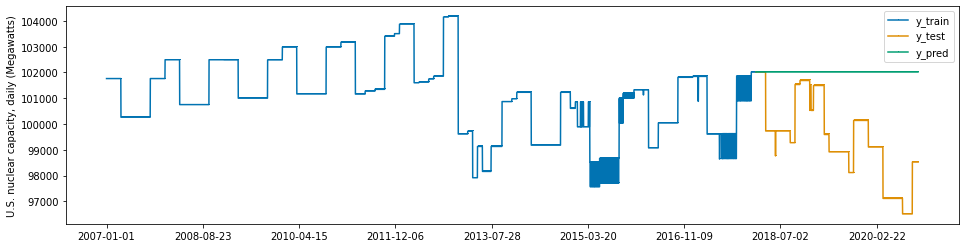

Seasonality: 30 MAE: 2571.851038575669


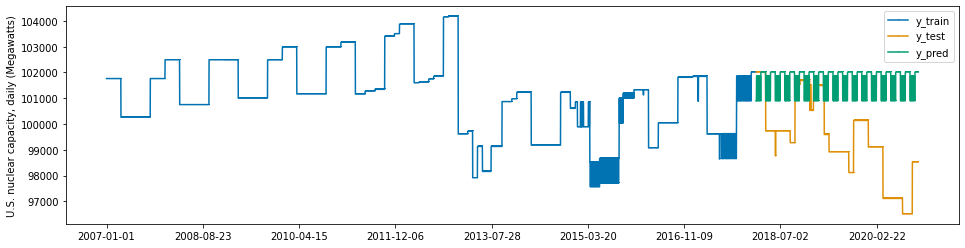

Seasonality: 60 MAE: 2370.802769535116


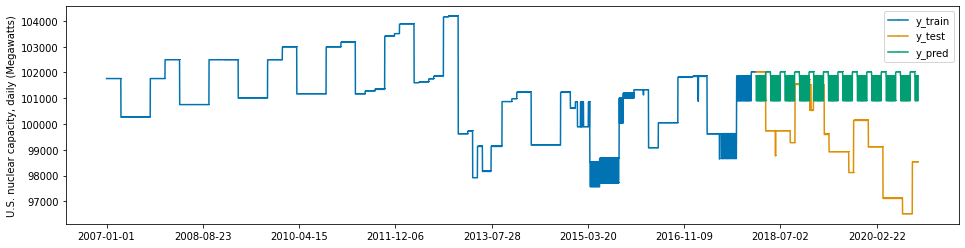

Seasonality: 90 MAE: 2346.9959446093003


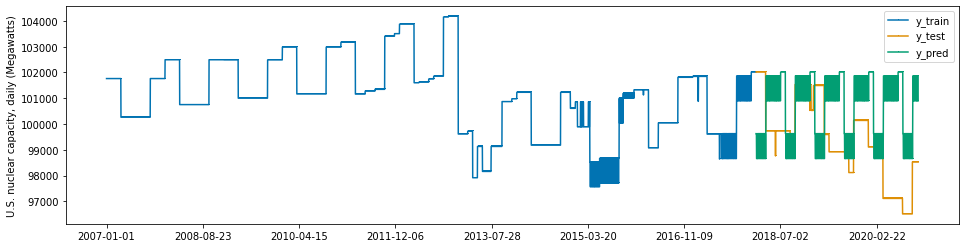

Seasonality: 183 MAE: 2037.666765578638


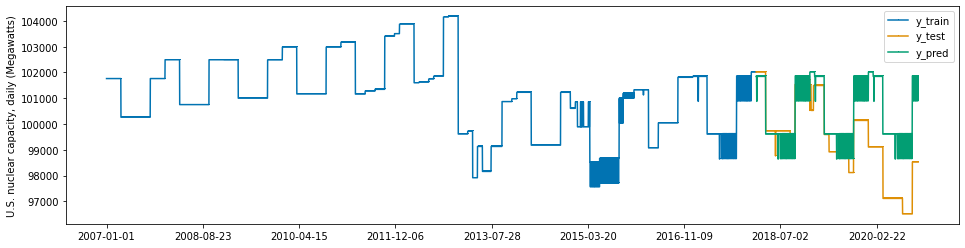

Seasonality: 365 MAE: 1202.4671612265095


In [ ]:
for sp in [30, 60, 90, 183, 365]:
    forecaster = NaiveForecaster(strategy='last', sp=sp)
    forecaster.fit(ts2_train)
    ts2_pred = forecaster.predict(fh)
    plot_series(ts2_train, ts2_test, ts2_pred, labels=["y_train", "y_test", "y_pred"], markers=[',', ',', ','])
    plt.show()
    print(f'Seasonality: {sp} MAE: {mean_absolute_error(ts2_pred, ts2_test)}')

### KTR из orbit (1 балл).



In [ ]:
from orbit.models.ktrlite import KTRLiteMAP

# ваш код обучения моделей здесь

In [ ]:
# посчитайте метрики на test

In [ ]:
ts2_train_df = ts2df(ts2_train)
ts2_test_df = ts2df(ts2_test)

In [ ]:
%%time

ktr = KTRLiteMAP(
    response_col='U.S. nuclear capacity, daily (Megawatts)',
    date_col='index',
    seasonality=[365]
)
ktr.fit(df=ts2_train_df)
ts2_pred = ktr.predict(df=ts2_test_df)

CPU times: user 3.62 s, sys: 378 ms, total: 4 s
Wall time: 3.8 s


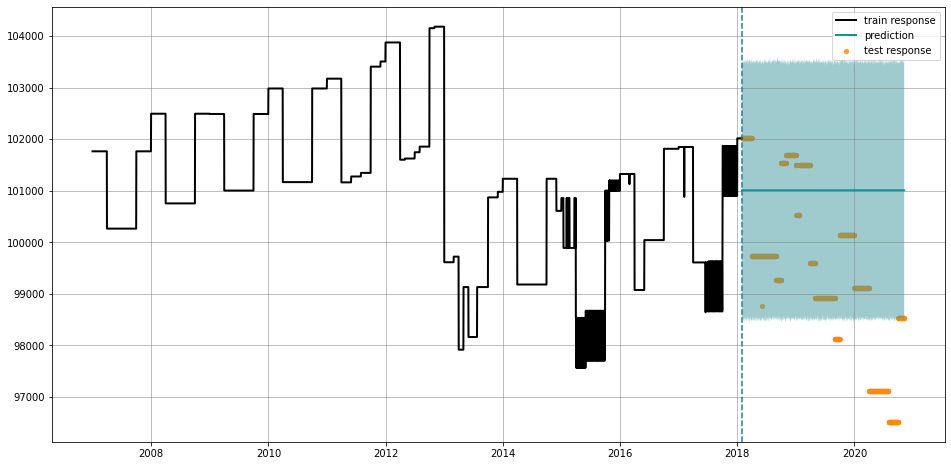

1869.5468546987013


In [ ]:
plot_predicted_data(
    training_actual_df=ts2_train_df, predicted_df=ts2_pred,
    date_col=ktr.date_col, actual_col=ktr.response_col,
    test_actual_df=ts2_test_df,
    insample_line=True
)
print(mean_absolute_error(ts2_pred['prediction'], ts2_test))

### Phophet (1 балл).



In [ ]:
from prophet import Prophet

# ваш код обучения моделей здесь

In [ ]:
# посчитайте метрики на test

In [ ]:
ts2_train_df_prophet = ts2_train_df.rename(columns={'index': 'ds', 'U.S. nuclear capacity, daily (Megawatts)': 'y'})
ts2_test_df_prophet = ts2_test_df.rename(columns={'index': 'ds', 'U.S. nuclear capacity, daily (Megawatts)': 'y'})

In [ ]:
%%time

model = Prophet()
model.fit(ts2_train_df_prophet)
ts2_pred = model.predict(ts2_test_df_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 9.16 s, sys: 3.16 s, total: 12.3 s
Wall time: 8.99 s


In [ ]:
ts2_pred_df = ts2_pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
ts2_pred_df = ts2_pred_df.rename(columns={'ds': 'index', 'yhat': 'prediction', 'yhat_lower': 'prediction_5', 'yhat_upper': 'prediction_95'})

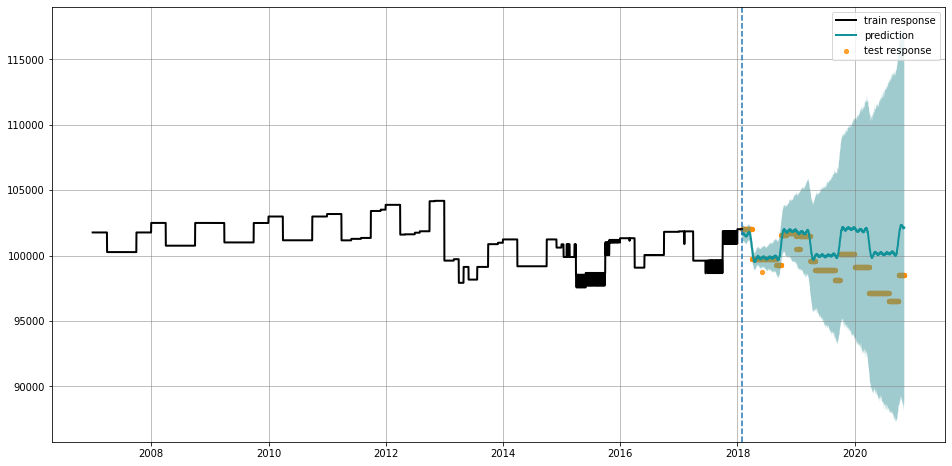

1486.689425661586


In [ ]:
plot_predicted_data(
    training_actual_df=ts2_train_df, predicted_df=ts2_pred_df,
    date_col='index', actual_col='U.S. nuclear capacity, daily (Megawatts)',
    test_actual_df=ts2_test_df,
    insample_line=True
)
print(mean_absolute_error(ts2_pred_df['prediction'], ts2_test))

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения.

In [ ]:
# нарисуйте пресказания

Лучшей моделью оказалось наивное предсказание с учетом годичной сезонности, однако оно не предполагает расчет доверительных интервалов.

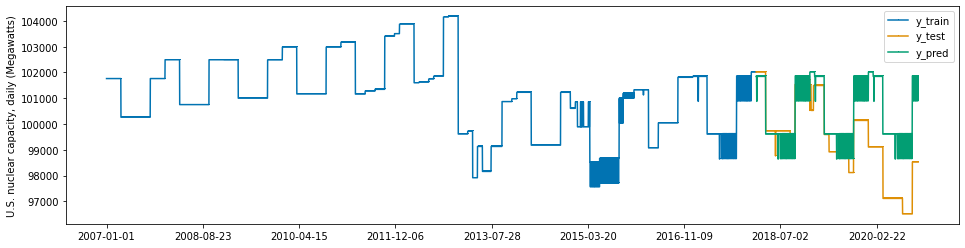

Seasonality: 365 MAE: 1202.4671612265095


In [ ]:
forecaster = NaiveForecaster(strategy='last', sp=365)
forecaster.fit(ts2_train)
ts2_pred = forecaster.predict(fh)
plot_series(ts2_train, ts2_test, ts2_pred, labels=["y_train", "y_test", "y_pred"], markers=[',', ',', ','])
plt.show()
print(f'Seasonality: {365} MAE: {mean_absolute_error(ts2_pred, ts2_test)}')

## Бонус. Напишите свою модель на STAN (3 балла).

Разработайте и испытай свою модель для месячного ряда в STAN.

Сравните качество прогнозов с наивной сезонной на тестовой выборке с помощью MAE. 



In [ ]:
# ваш код модели на STAN и её обучения моделей здесь

In [ ]:
# посчитайте метрики на test

In [ ]:
# нарисуйте пресказания